In this notebook, I will demonstrate how to perform adaptive stitching and avoid cutting through freestanding parts. This is demonstrated on a microlensarray. 

In [39]:
%pylab

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import TipSlicer
import cv2
import scipy.ndimage as im
import tables
from importlib import reload
import os
import scipy.io
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [51]:
x=arange(-1000,1000,1)
y=arange(-1000,1000,1)
X,Y=np.meshgrid(x,y)
print(Y.shape)

(2000, 2000)


In [52]:
samples = (800,800)
xgrng = np.array((-1800, 1800)) #in microns 
ygrng=xgrng
yg = np.linspace(ygrng[0], ygrng[1], samples[0])
xg=yg
px=xg[1] - xg[0]
py=px
X,Y= np.meshgrid(xg,yg)

In [53]:
file_best = '/home/kyrollos/randoscope/bestPrintSurface.mat'
file_best2 = '/home/kyrollos/randoscope/BestAndWorst/best_initPrint.mat'
loaded2 = scipy.io.loadmat(file_best2)
loaded = scipy.io.loadmat(file_best)
T=loaded['T']
xpos=loaded2['x_best']
ypos=loaded2['y_best']
xpos=np.reshape(xpos,(31))*1000
ypos=np.reshape(ypos,(31))*1000

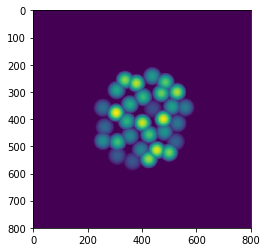

In [54]:
plt.imshow(T)

In [58]:
def myFigure(X,Y,z,extras):
    D=np.sqrt(X**2+Y**2)
    Xp=(2-cos(D/1000*0.3*np.pi))*X
    Yp=(2-cos(D/1000*0.3*np.pi))*Y
    period=50
    cut=12
    z2=2*z
    T1=TipSlicer.hexagonalSlice(Xp,Yp,z2,[20,period,-cut])
    
    Tc=T1.copy()
    Tc=np.where(X<-1000,0,Tc)
    Tc=np.where(X>1000,0,Tc)
    Tc=np.where(Y<-1000,0,Tc)
    Tc=np.where(Y>1000,0,Tc)
    
    border=3
    Tc[0:border]=0
    Tc[-border:]=0
    Tc[:,0:border]=0
    Tc[:,-border:]=0
    return Tc

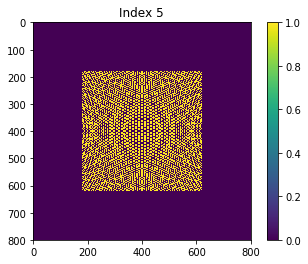

In [63]:
ind=5
T=myFigure(X,Y,ind,0)
clf()
plt.imshow(T)
plt.colorbar()
title('Index {}'.format(ind))
ind=ind+1

In [ ]:
np.shape(T)


In [ ]:
Tc=im.binary_closing(T,iterations=10)
imshow(Tc)

=> 10 iterations of binary_closing is enough to merge all microlenses.

In [18]:
freePs=np.zeros((len(xpos),2))
for i in range (0,len(xpos)):
    freePs[i,0]=xpos[i]
    freePs[i,1]=ypos[i]

In [ ]:
%%%time
freePs,freeLabPos,freeLabs=TipSlicer.getOptimalFreestandingStitchCentres(T,150,150,X,Y,10)
print(len(freePs))

In [19]:
freePs

array([[ 4.47636932e+02,  5.52202209e+02],
       [ 3.20696564e+02, -4.25018738e+02],
       [ 1.70076843e+02, -7.07452759e+02],
       [ 5.54960388e+02,  3.74717712e+02],
       [-4.27550812e+02, -1.04410110e+02],
       [ 5.85507385e+02,  6.98503342e+01],
       [ 4.96865051e+02, -2.03342773e+02],
       [-1.77188396e+01,  5.08330231e+02],
       [-6.45808533e+02, -1.84420639e+02],
       [-4.03727661e+02,  3.78593323e+02],
       [ 3.70860779e+02,  2.12108215e+02],
       [-2.51128586e+02,  3.54825554e+01],
       [ 1.79993057e+02, -1.70359360e+02],
       [ 1.98985596e+01, -3.62990662e+02],
       [-9.18188934e+01, -5.89994690e+02],
       [ 3.53299622e+02, -6.11556888e-01],
       [ 1.19957779e+02,  2.57582581e+02],
       [-6.13918335e+02,  1.32193176e+02],
       [-1.99387024e+02, -2.42584183e+02],
       [-4.17970490e+02, -4.77580200e+02],
       [ 7.13910034e+02, -1.91032318e+02],
       [ 5.77655029e+02, -4.44720825e+02],
       [ 1.10366150e+02,  6.61341248e+02],
       [-4.

In [ ]:
amLabs2=[len(freeLab) for freeLab in freeLabs]

In [ ]:
clf()
#plot(amLabs,'o')
plot(amLabs2,'x')
grid()

In [ ]:
freePs=TipSlicer.getHexStitchCentres(T,150,X,Y)
print(len(hexPos))

In [ ]:
freePs=TipSlicer.getSquareStitchCentres(T,150/np.sqrt(2),X,Y)
print(len(sqPos))

In [ ]:
%%%time
# now find optimal solution with CONCORDE and CPLEX
TipSlicer.writeTSPfile('blocks.tsp',freePs)
!concorde -o 'tsp.sol' 'blocks.tsp'
Ord=TipSlicer.readTSPfile('tsp.sol')


In [ ]:
clf()
plot(freePs[Ord][:,0],freePs[Ord][:,1],'.-')

In [ ]:
# If you do not have concorde, try the nearest neighbour ordering
Ord,NNd=TipSlicer.TSPnearest(freePs)

In [ ]:
Ord

In [ ]:
#%%%time
# STEP 5: Write out stacks
FovZ=45
Fov=300
hatching=0.5
slicing=3

amShells=2
ScaffStep=2 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False


am=np.int(np.round(Fov/hatching))
#amY=np.int(np.round(FovY/hatching))
zz=np.arange(0,FovZ,slicing)


dirName='MicroLensArrayMiniscope'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'

#sliceIndList=np.arange(0,FovZ+slicing,slicing)

#print(len(sliceIndList))
#print(sliceIndList)
#print(zz[sliceIndList])

fullDist=[]
allBlocks=[]
for i in np.arange(0,len(Ord)):
#for i in np.arange(0,10):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=freePs[Ord][i,0]
    yc=freePs[Ord][i,1]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    # make the writing mask
    seeds=TipSlicer.convertToPixels(Xloc,Yloc,freeLabPos[Ord[i]])
    Tloc=myFigure(Xloc,Yloc,0,0)
    MM=TipSlicer.makeFreeMaterialMatrix(Tloc,seeds)
    
#    MM=FormulaSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    TipSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=0,writingMask=MM)
    allBlocks.append(blockName)
    # and write the GWL's
    #print(sliceIndList)
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep,
                                   codeSpeeds=[50000,50000,50000],codeIntens=[30,33,35],atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
    if (len(dists)>0):
        if (len(fullDist)==0):
            fullDist=dists
        else:
            fullDist=fullDist+dists

    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)

#writeTime=(fullDist/CodeSpeeds[:len(fullDist)]).sum()/3600.
#print('Printing will take +- {:.2f} hours'.format(writeTime))

In [ ]:
CodeSpeeds=np.array([30000,30000,30000])
writeTime=(fullDist/CodeSpeeds[:len(fullDist)]).sum()/3600.
print('Printing will take +- {:.2f} hours'.format(writeTime))

# Now do hexagonal tiling

In [ ]:
hexPos=TipSlicer.getHexStitchCentres(T,150,X,Y)
print(len(hexPos))

In [ ]:
# STEP 4: Make voronoi tesselation
regions, vertices = TipSlicer.makeVoronoiPolygons(hexPos)
#ffOpt=FormulaSlicer.getInfillRatio(regions,vertices,T,X,Y)

# and display it
clf()
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.6)

plt.plot(hexPos[:,0], hexPos[:,1], 'ko')
plt.axis('equal')
#plt.xlim(vor.min_bound[0] - 20, vor.max_bound[0] + 20)
#plt.ylim(vor.min_bound[1] - 20, vor.max_bound[1] + 20)

plt.imshow(T,alpha=0.8,extent=(X.min(),X.max(),Y.max(),Y.min()))
display(gcf())

In [ ]:
%%%time
# now find optimal solution with CONCORDE and CPLEX
pp=hexPos
TipSlicer.writeTSPfile('blocks.tsp',pp)
!concorde -o 'tsp.sol' 'blocks.tsp'
Ord=TipSlicer.readTSPfile('tsp.sol')

In [ ]:
#%%%time
# STEP 5: Write out stacks
FovZ=45
Fov=300
hatching=0.5
slicing=3

amShells=2
ScaffStep=2 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False
#CodeSpeeds=np.ones(3)*30000
#CodeIntensities=np.ones(3)*80


am=np.int(np.round(Fov/hatching))
#amY=np.int(np.round(FovY/hatching))
zz=np.arange(0,FovZ,slicing)


dirName='MicroLensesHexagonal'
if (not os.path.exists(dirName)):
    os.mkdir(dirName)
genBlockName=dirName+'/'+dirName+'Block-{:05d}.h5'
genGwlName=dirName+'/'+dirName+'Block-{:05d}.gwl'
genRegex=dirName+'/.+gwl'
fullGwlName=dirName+'.gwl'

for i in np.arange(len(Ord)):
#for i in np.arange(10):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=hexPos[Ord[i],0]
    yc=hexPos[Ord[i],1]
    polygon = vertices[regions[Ord[i]]]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    MM=TipSlicer.makeVoronoiMask(polygon,Xloc,Yloc)
    # if you need overlap, do binary_dilation on the mask
    MM=im.binary_dilation(MM,iterations=2)
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    # make a formula for formulaToStack for SERPENTIN!!!
    TipSlicer.formulaToStack(blockName,Xloc,Yloc,zz,myFigure,extraParams=0,writingMask=MM)
    
    # and write the GWL's
    dists=TipSlicer.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,atAngles=-1,writeHeader=False,writeColourH5=False,doTopBottom=True)
    
TipSlicer.writeGwlForRegex(fullGwlName,genRegex)#,CodeSpeeds,CodeIntensities)